## About Dataset
### Problem description
This directory contains data to train a model to predict the function of protein domains, based on the PFam dataset.

Domains are functional sub-parts of proteins; much like images in ImageNet are pre segmented to contain exactly one object class, this data is presegmented to contain exactly and only one domain.

The purpose of the dataset is to repose the PFam seed dataset as a multiclass classification machine learning task.

The task is: given the amino acid sequence of the protein domain, predict which class it belongs to. There are about 1 million training examples, and 18,000 output classes.

### Data structure
This data is more completely described by the publication "Can Deep Learning Classify the Protein Universe", Bileschi et al.

### Data split and layout
The approach used to partition the data into training/dev/testing folds is a random split.

Training data should be used to train your models. Dev (development) data should be used in a close validation loop (maybe for hyperparameter tuning or model validation). Test data should be reserved for much less frequent evaluations - this helps avoid overfitting on your test data, as it should only be used infrequently.

### File content
Each fold (train, dev, test) has a number of files in it. Each of those files contains csv on each line, which has the following fields:

- sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE
- family_accession: PF02953.15
- sequence_name: C5K6N5_PERM5/28-87
- aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE
- family_id: zf-Tim10_DDP

#### Description of fields:
- sequence: These are usually the input features to your model. Amino acid sequence for this domain.
There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.
- family_accession: These are usually the labels for your model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.
- family_id: One word name for family.
- sequencename: Sequence name, in the form " 𝑢𝑛𝑖𝑝𝑟𝑜𝑡𝑎𝑐𝑐𝑒𝑠𝑠𝑖𝑜𝑛𝑖𝑑/ startindex-$end_index". aligned_sequence: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained. <p> 
Generally, the family_accession field is the label, and the sequence (or aligned sequence) is the training feature.

This sequence corresponds to a domain, not a full protein.

<b> THIS DESCRIPTION WAS TAKEN FROM KAGGLE - ALSO NOTE: THIS DATA HAS A LISCENSE AND MAY NOT BE USED OUTSIDE OF PUBLIC FREE PROJECTS WITHOUT PERMISSION <b>

In [ ]:
!pip install python-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

!cp './drive/MyDrive/Colab Notebooks/ProtCNN/utils/datautils.py' ./
from datautils import reader, build_labels, get_amino_acid_frequencies, build_vocab

Mounted at /content/drive/


In [ ]:
base_dir = './drive/MyDrive/PFAM_database'
data_dir = base_dir+'/data/random_split/'

### Step 1. Define Data Loading and Preprocessing

Here we'll define the reader function which looks at the [partition], or the 'train'/'test' subdirectories, found within the [data_dir] directory and reads all files as csvs found in the subdirectories. These csv contain the data fields as described above (taken from [kaggle](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split)) but the <b> reader </b> function only extractions the columns "sequence" and "family accession" as the data and targets respectively.

In [ ]:
help(reader)

Help on function reader in module datautils:

reader(partition: str, data_path: str) -> pandas.core.series.Series
    This function reads in a list of csv files found in data_path/partition and returns two pd.Series
    Args:
      partition: str
        - this is designed to accept strs 'train', 'test', or 'dev'
      data_path: str
        - this is designed to be the directory to the data downloaded from kaggle and expects to see the subdirectory options detailed in partition
    Output:
      all_data['sequence']: pd.Series (strings)
        - this pd.Series is a column of sequence data from the csvs. This is typically the main feature in protein classification Amino acid sequence 
            for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.
      all_data['family_accession]: pd.Series
      - this pd.Series is a column of family data from the csvs. Accession number in form PFxxxxx.y (Pfam), whe

In [ ]:
train_data, train_targets = reader('train',data_dir)
test_data, test_targets = reader('test',data_dir)

Now that we've read in our data and labels, we want to transform the labels. We'll use build_labels to do this. This function grabs the unique values in the label data and calculates the frequencies they appear, also counting the number of unique labels. 

In [ ]:
from datautils import build_labels

In [ ]:
fam2label = build_labels(train_targets)

There are 17930 labels.


In [ ]:
print(len(train_data), len(test_data))

1086741 126171


we've got 17930 unique labels of various frequencies. This is in contrast to our 1,086,741 individual sequences for our training data. 

It should be noted that the paper this is based off of this [paper](https://www.biorxiv.org/content/10.1101/626507v3.full) trained just under 1.1M (similar number of examples) with 17929 output families - this is the same number as ours, we just already have the $unk$ family label. To determine how well we expect to be able to predict each class, we need to do a little EDA.

#### Data Exploration and Analysis: Plots

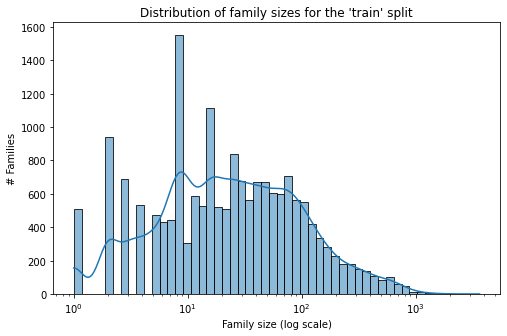

In [ ]:
#Plot distribution of family sizes
f, ax = plt.subplots(figsize = (8,5))

sorted_train_targets = train_targets \
    .groupby(train_targets) \
    .size() \
    .sort_values(ascending = False)

sns.histplot(sorted_train_targets.values, kde = True, log_scale = True, ax = ax)
#kde - use kernel density estimate to smooth distribution

plt.title("Distribution of family sizes for the 'train' split")
plt.xlabel("Family size (log scale)")
plt.ylabel("# Families")
plt.show()

Here we can see we have a heavily imbalanced distribution. This means that we have some families with only 10s of examples (that $10^0$ is our $unk$ label) and a few with several thousand. We'll need to address the families with little to no representations. This is also discussed in the [paper]('https://www.biorxiv.org/content/10.1101/626507v3.full') where they found that the 'small families' (or labels with some minimal frequency) are better off predicted after the base ProtCNN model is developed with a One-Shot NN.

Aside from the label distributions, we're interested in the distributions of the sequence lengths

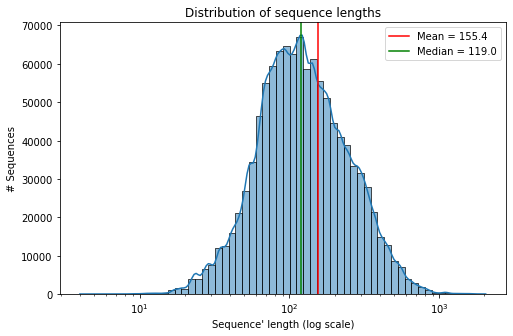

In [ ]:
 # Plot the distribution of sequences' lengths
f, ax = plt.subplots(figsize=(8, 5))
train_sequence_lengths = train_data.str.len()

train_median = train_sequence_lengths.median()

train_mean = train_sequence_lengths.mean()

sns.histplot(train_sequence_lengths.values, kde=True, log_scale=True, bins=60, ax=ax)

ax.axvline(train_mean, color='r', linestyle='-', label=f"Mean = {train_mean:.1f}")

ax.axvline(train_median, color='g', linestyle='-', label=f"Median = {train_median:.1f}")

plt.title("Distribution of sequence lengths")
plt.xlabel("Sequence' length (log scale)")
plt.ylabel("# Sequences")
plt.legend(loc="best")
plt.show()

Here we can see we're 'almost' normally distributed but we've got a pretty large range of sequence lengths in our data.

In [ ]:
help(get_amino_acid_frequencies)

Help on function get_amino_acid_frequencies in module datautils:

get_amino_acid_frequencies(data: pandas.core.series.Series) -> Empty DataFrame
Columns: []
Index: []
    get_amino_acid_frequencies uses a counter to count recurring sequences within the data
    Args:
      data: pd.Series
        - This data is the sequence data made into a pd.Series via the previous reader() function
    Output:
      pd.DataFrame()
        - this dataframe contains the keys and values of the counted sequence data



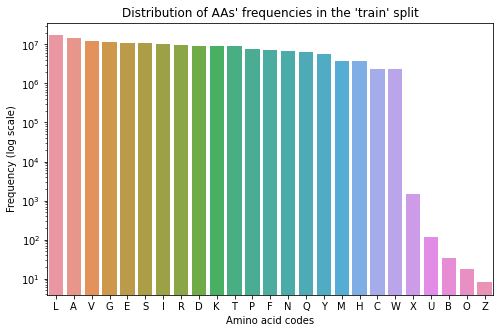

In [ ]:
 # Plot the distribution of AA frequencies

f, ax = plt.subplots(figsize=(8, 5))
amino_acid_counter = get_amino_acid_frequencies(train_data)

sns.barplot(x='AA', y='Frequency', data=amino_acid_counter.sort_values(by=['Frequency'], ascending=False), ax=ax)
plt.title("Distribution of AAs' frequencies in the 'train' split")
plt.xlabel("Amino acid codes")
plt.ylabel("Frequency (log scale)")
plt.yscale("log")
plt.show()

As reported in the paper (and problem prompt) there are some amino acids which are very rare (X, U, B, O, Z). As such, we can push these to the $unk$ family. We could eventually remove these and push them into a One-Shot Learner.

Now that we have our amino acid code frequences, we're going to build a vocabulary. If any sequence is rare, we'll excluded them and instead have them be $unk$. 


This is a good eda that shows us what feature engineering we have to do, the removal of the XUBOZ codes. With this we can move on to the model development